In [2]:
import os
import matplotlib.pyplot as plt
import json
import numpy as np
from sklearn.decomposition import PCA
import pickle

import sys
sys.path.insert(0, '../')
from forest3D import lidar_IO,treeDetector,ground_removal,utilities,detection_tools
from forest3D.pcd import read_pcd
from forest3D import detection_tools,processLidar
from forest3D import lidar_IO,treeDetectorYolov3 as treeDetector,ground_removal,utilities,detection_tools
from forest3D.object_detectors import detectObjects_yolov3 as detectObjects
import matplotlib.pyplot as plt


# 3d to 2d slices

1. Converting 3d image to 2d slices.

In [10]:


grid_size = [600, 600, 1000]
grid_res = 0.1
output_dir = '../../data/'
# config_dict = {'raster_layers': ['vertical_density', 'canopy_height'], 'support_window': [11, 7, 1],
#                'normalisation': 'rescale+histeq','doHisteq':[False,True],'res': 0.1, 'gridSize': }

config_dict = {"doHisteq": [False, True], "raster_layers": ["vertical_density", "canopy_height"], "gridSize": grid_size, "res": grid_res, "support_window": [11, 7, 1], "normalisation": "rescale+histeq"}

rasterMaker = treeDetector.RasterDetector(**config_dict)


# PCD file
path = "../../data/pcd_files/160_2-170_2_slam.pcd"
pcd_file = read_pcd(path)
xyz_data = pcd_file['points'][['x','y','z']].values
offset = [0,0,0]




box_store = np.zeros((1, 4))
counter = 0
windowSize = [50,50]
stepSize = 40

xyz_data_gr = ground_removal.removeGround(xyz_data,offset,thresh=2.0,proc_path=output_dir)
ground_pts = ground_removal.load_ground_surface(os.path.join(output_dir,'_ground_surface.ply'))

xyz_clr_data = xyz_data
slices = detection_tools.sliding_window_3d(xyz_clr_data, stepSize=stepSize,windowSize=windowSize)
for (x, y, window) in slices:  # stepsize 100

    # track progress
    counter = counter 
    totalCount = len(range(int(np.min(xyz_data[:, 0])), int(np.max(xyz_data[:, 0])),stepSize)) * \
                 len(range(int(np.min(xyz_data[:, 1])), int(np.max(xyz_data[:, 1])),stepSize))
    sys.stdout.write("\r%d out of %d tiles" % (counter, totalCount))
    sys.stdout.flush()


0 out of 300 tiles

# Getting Slices 1 by 1

In [4]:
slices = detection_tools.sliding_window_3d(xyz_clr_data, stepSize=stepSize,windowSize=windowSize)


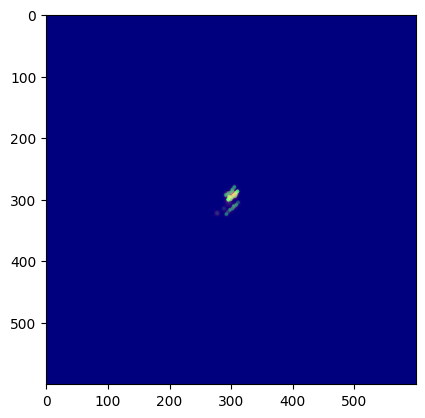

In [5]:
# print(slices)

while  True:
    x, y, window = next(slices)
    if window is not None: break
image, center =rasterMaker._rasterise(window, ground_pts=ground_pts)
image = np.uint8(image*255)
plt.imshow(image)
plt.show()

# Predict Yolov5


In [6]:
import torch
weights = "/forest_3d_app/yolov5/runs/train/exp7/weights/best.pt"

model = torch.hub.load('ultralytics/yolov5', 'custom', weights)
def convert_to_percentage(box, total_width, total_height):
    x, y, w, h = box 
    x_percent = x / total_width
    y_percent = y / total_height
    w_percent = w / total_width
    h_percent = h / total_height

    return np.asarray([x_percent, y_percent, w_percent, h_percent])


def xywh_to_x1y1x3y2(box):
    centerX, centerY, width, height =box
    return [centerY-(height/2.0),centerX-(width/2.0),centerY+(height/2.0),centerX+(width/2.0)]

def detectObjects_yolov5(img):
    
    import matplotlib.pyplot as plt
    import random
    # plt.imsave(f"/forest_3d_app/3d_forest/forest_3d_app/data/test_images/{int(random.random()*100000)}test.png",img)
    # plt.imshow(img)
    # plt.show()
    results = model(img)
    list_bbox = [xywh_to_x1y1x3y2(i) for i in np.asarray(results.pandas().xywh[0][["xcenter", "ycenter", "width","height"]].values)]
    
    
    
    list_conf = np.asarray(results.pandas().xyxy[0]["confidence"].values)
    list_class = np.asarray(results.pandas().xyxy[0]["name"].values)
    list_class = [0 for i in list_class]
    boxes = np.array(list_bbox, np.float64)


    image_width, image_height, channel = img.shape
    percent_boxes = []
    for i in boxes:
        
        percent_boxes.append(convert_to_percentage(i, image_width, image_height))
    return img,percent_boxes,np.array(list_class),np.array(list_conf)



/3d_forest/miniconda3/envs/3d_forest/lib/python3.9/site-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: Ultralytics requirement "gitpython>=3.1.30" not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7

# Yolov5 to 3d Boxes

In [7]:
boxesV5 = detectObjects_yolov5(image)
boxesV5 = np.asarray(boxesV5[1])
boxesV5

bb_coord = detection_tools.boundingBox_to_3dcoords(boxes_=boxesV5, gridSize_=grid_size[0:2], gridRes_=grid_res,
                                                                      windowSize_=windowSize, pcdCenter_=center)
print(bb_coord)

with open("/forest_3d_app/3d_forest/forest_3d_app/data/150_2-160_2_slam.txt", "w") as f:
    np.savetxt(f, bb_coord)

type(bb_coord)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

# Perdict full PCD file

In [11]:
boxes= []


slices = detection_tools.sliding_window_3d(xyz_clr_data, stepSize=stepSize,windowSize=windowSize)

iterator = 0
while  True:
    
    x, y, window = next(slices)
    if window is not None:
        image, center =rasterMaker._rasterise(window, ground_pts=ground_pts)
        image = np.uint8(image*255)
        plt.imshow(image)
        plt.show()


        # Predicting
        boxesV5 = np.asarray(detectObjects_yolov5(image)[1])
        print(boxesV5)
        if len(boxesV5):

            bb_coord = detection_tools.boundingBox_to_3dcoords(boxes_=boxesV5, gridSize_=grid_size[0:2], gridRes_=grid_res,
                                                                                  windowSize_=windowSize, pcdCenter_=center)
            boxes.append(bb_coord)
            iterator += 1
            
            



[[    0.12414     0.37747     0.53654        0.59]
 [  0.0013129     0.48197     0.11302      0.5891]
 [    0.58814     0.29177     0.72877     0.55463]
 [          0     0.40306     0.37929     0.58917]
 [     0.6345   0.0002091     0.73313      0.1279]
 [    0.44293     0.35678     0.62835     0.57147]]
[[    0.70151       0.157     0.84001     0.30209]
 [   0.010741     0.84128     0.27121           1]
 [    0.59556     0.15521     0.72508     0.31113]
 [    0.71546     0.62246     0.84855     0.98219]
 [  0.0090096     0.17502     0.25078     0.44457]
 [    0.26772     0.66008     0.70817           1]
 [    0.26877     0.18346     0.46594     0.42647]
 [    0.79957     0.16144     0.84435     0.26658]]
[[     0.3394       0.358      0.7918     0.60992]
 [   0.076466     0.38146     0.33556      0.5739]
 [    0.81394     0.36489     0.91724     0.59858]]
[]
[]
[]
[]
[[    0.25514     0.44167     0.43103     0.60241]
 [    0.72931     0.29602     0.83139      0.4395]
 [    0.50177   

[[    0.91371     0.59569     0.95257     0.65842]
 [    0.19404     0.28279     0.36063     0.46144]
 [    0.30533     0.13665     0.55688     0.41049]
 [    0.45417    0.084288     0.66276     0.20378]
 [    0.70221     0.78353     0.88892     0.92959]]
[[    0.43451     0.70691     0.55782     0.86071]
 [    0.33539     0.80772     0.49936     0.98697]
 [    0.50958     0.65141     0.61687     0.77226]
 [    0.71652     0.18519     0.85856     0.38338]
 [     0.6782     0.33652     0.82059     0.51287]
 [     0.5768     0.40739     0.71752     0.66793]
 [    0.17365     0.93539     0.22423     0.98457]]
[[    0.28048     0.35536     0.39004     0.51613]
 [    0.34156     0.29397     0.43228     0.39099]
 [    0.40665     0.16641     0.49941     0.28766]
 [    0.18449     0.59412     0.29509      0.6961]
 [    0.16356     0.30102     0.25157     0.42359]
 [    0.18782      0.6847      0.2394     0.73331]
 [    0.45239     0.15957     0.54655     0.21258]]
[]
[]
[]
[]
[]
[[    0.31776

StopIteration: 

In [12]:
flattened_list = [item for sublist in boxes for item in sublist]
npboxes = np.asarray(flattened_list)
with open("/forest_3d_app/3d_forest/forest_3d_app/data/150_2-160_2_slam.txt", "w") as f:
    np.savetxt(f, npboxes)

# type(bb_coord)
